# TP4 - ConvGLU

Dans cette séance on souhaite implémenter plusieurs des techniques que l'on a vu en cours. Et particulièrement, on se pose la question de l'adaptation de couches GLU au réseau convolutionnel : et si on remplaçait les couches denses par des couches convolutionnelles ? 

Pour tester cette idée, qui peut ne rien donner, nous allons à nouveau travailler avec le dataset [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) pour pouvoir comparer un peu aux TP précédents. Commençons par importer les données.

In [19]:
import pandas as pd
import tensorflow as tf 
import tensorflow_datasets as tfds
import keras
import keras_cv

dataset = tfds.load("cifar10", as_supervised=True)
dataset_train, dataset_test = dataset["train"], dataset["test"]

Rappellons que les deux datasets sont des [tensorflow dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset). Nous allons pré-traiter les données de la même manière.

In [20]:
image_size = (64, 64)
n_class = 102
batch_size = 526

def process_dataset(image, label):
    image = tf.image.resize(image, image_size)
    image = tf.cast(image, tf.float32)
    label = tf.one_hot(label, n_class)
    return {"images": image, "labels": label}

dataset_train = dataset_train.map(process_dataset).batch(batch_size)

Nous avions également une fonction qui nous permet de visualiser le dataset :

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

def visualize_dataset(dataset, title, figsize=(6, 6)):
    plt.figure(figsize=figsize)

    for index, sample in enumerate(iter(dataset.take(9))):
        images = sample["images"]
        plt.subplot(3, 3, index + 1)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.axis("off")
    
    plt.suptitle(title, fontsize=14)
    plt.show()

2024-05-17 11:41:02.380440: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-17 11:41:02.408981: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


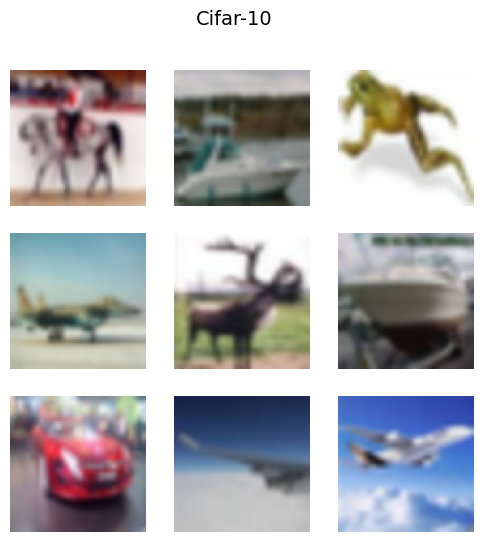

In [22]:
visualize_dataset(dataset_train, "Cifar-10")

## Augmentation du dataset

Avant de travailler sur l'architecture, fixons l'augmentation du dataset. Notons que, pour le moment, dans la fonction `process_dataset` nous n'avons pas normaliser les données entre 0 et 1.

**Consigne** : À l'aide du TP précédent, utiliser quelques couches d'[augmentations](https://keras.io/api/layers/preprocessing_layers/image_augmentation/) (et/ou aussi [ici](https://keras.io/api/keras_cv/layers/augmentation/)) pour construire un ensemble d'augmentation. Puis visualiser les changements.

2024-05-17 11:41:23.078573: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-17 11:41:23.096497: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


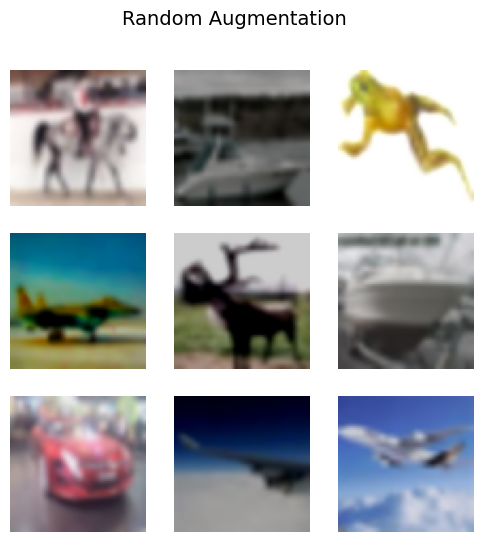

In [23]:
augmentation = keras_cv.layers.Augmenter([
    keras_cv.layers.RandomContrast(factor=0.25, value_range=(0, 255)),
    keras_cv.layers.RandomFlip(mode="horizontal"),
    keras_cv.layers.RandomBrightness(factor=0.25, value_range=(0, 255)),
    keras_cv.layers.RandomSharpness(factor=(0.25, 0.75), value_range=(0, 255)),
    keras_cv.layers.RandomSaturation(factor=(0.25, 0.75)),
])

dataset_augmentation = dataset_train.map(lambda samples: augmentation(samples))
visualize_dataset(dataset_augmentation, "Random Augmentation")

## Couche ConvGLU

On souhaite tester l'idée des Gated Linear Unit (GLU) avec des couches de convolutions. Cependant, il n'existe pas de fonctions déjà prête dans Keras pour le faire. Nous allons devoir créer notre propre couche.

**Consigne** : Construire la classe `ConvGLU` qui hérite de [`keras.layers.Layer`](https://keras.io/api/layers/). Elle prendra en paramètre le chaîne de caractère *activation* qui correspond à la fonction d'activation que l'on souhaite utiliser pour le côté *Gated*. On utilisera également les *kwargs* pour passer des paramètres classiques de keras.
Nous n'avons qu'a spécifier la méthode `call` qui correspond à l'appel de la couche.

In [ ]:
class ConvGLU(keras.layers.Layer):

    def __init__(self, activation, **kwargs):
        super().__init__()
        self.convolution_before = keras.layers.Conv2D(activation="linear", **kwargs)
        self.activation = keras.layers.Conv2D(activation=activation, **kwargs)
        self.convolution_after = keras.layers.Conv2D(activation="linear", **kwargs)

    def call(self, inputs):
        outputs = self.convolution_before(inputs) * self.activation(inputs)
        return self.convolution_after(outputs)

Nous avons l'ensemble des briques pour pouvoir construire notre réseau. 

**Consigne** : Définir une fonction `get_model` qui prend en paramètre une chaîne de caractère *activation* qui correspond à la fonction d'activation à transmettre à la couche `ConvGLU`. La fonction renverra le modèle à entraîner. Commencer le modèle par une couche [`keras.layers.Input`](https://keras.io/api/layers/core_layers/input/).

In [ ]:
def get_model(activation="relu"):
    model = keras.models.Sequential([
        keras.layers.Input(shape=(64, 64, 3)),
        ConvGLU(filters=64, kernel_size=7, padding="same", activation=activation, kernel_initializer="he_normal"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=3),

        ConvGLU(filters=64, kernel_size=7, padding="same", activation=activation, kernel_initializer="he_normal"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=3),

        ConvGLU(filters=64, kernel_size=7, padding="same", activation=activation, kernel_initializer="he_normal"),
        keras.layers.BatchNormalization(),

        keras.layers.Flatten(),
        keras.layers.Dense(units=128, kernel_initializer="he_normal", activation="relu"),
        keras.layers.Dense(units=64, kernel_initializer="he_normal", activation="relu"),
        keras.layers.Dense(units=10, kernel_initializer="he_normal", activation="softmax")
    ])
    
    return model

## Échéancier cosinus

On souhaite entraîner le modèle avec un échéancier cosinus. L'implémentation keras est réalisée avec un changement du learning rate à chaque batch, et on souhaiterai avoir un paramétrage par époques.

**Consigne** : Définir une fonction `get_cosine_scheduler` qui prend en paramètre :
* *batch_per_epoch*: le nombre de batch par époques
* *decay_epochs*: le nombre d'époque où le learning rate va baisser
* *warmup_epochs*: le nombre d'époque de chauffe

On intégrera également les *kwargs* pour que l'on puisse passer les paramètres clé à la classe [`CosineDecay`](https://keras.io/api/optimizers/learning_rate_schedules/cosine_decay/), par exemple le learning rate, la réduction du learning rate... La fonction renverra l'objet *schedule* pour pouvoir l'intégrer dans la description de l'entraînement du modèle.

In [ ]:
def get_cosine_scheduler(batch_per_epoch, decay_epochs, warmup_epochs, **parameters):
    decay_steps = batch_per_epoch * decay_epochs
    warmup_steps = batch_per_epoch * warmup_epochs
    schedule = keras.optimizers.schedules.CosineDecay(
        decay_steps = decay_steps,
        warmup_steps = warmup_steps,
        **parameters
    )
    return schedule

## Entraînement

Nous avons l'ensemble des briques nécessaire pour pouvoir tester notre idée. Il faut, avant de lancer l'entraînement, modifier le preprocessing pour normaliser les données.

**Consigne** : Modifier la fonction `process_dataset` pour qu'elle normalise les données entre 0 et 1.

In [24]:
def process_dataset(image, label):
    image = tf.image.resize(image, image_size)
    image = tf.divide(image, 255)
    image = tf.cast(image, tf.float32)
    label = tf.one_hot(label, n_class)
    return {"images": image, "labels": label}

**Consigne** : Adapter en conséquence la liste des augmentations.

In [25]:
augmentation = keras_cv.layers.Augmenter([
    keras_cv.layers.RandomContrast(factor=0.25, value_range=(0, 1)),
    keras_cv.layers.RandomFlip(mode="horizontal"),
    keras_cv.layers.RandomBrightness(factor=0.25, value_range=(0, 1)),
    keras_cv.layers.RandomSharpness(factor=(0.25, 0.75), value_range=(0, 1)),
    keras_cv.layers.RandomSaturation(factor=(0.25, 0.75)),
])

**Consigne** : Définir une fonction `get_dataset` qui renvoie le dataset d'entraînement et de validation, avec l'application des augmentations pour le dataset d'entraînement.

In [ ]:
def get_dataset():

    def augment(image, label):
        output = augmentation({"images": image, "labels": label})
        return output['images'], output['labels']

    train = dataset_train.shuffle(10*batch_size).map(process_dataset).cache().batch(batch_size).map(augment)
    test = dataset_test.map(process_dataset).cache().batch(batch_size)
    return train, test

**Consigne** : Entraîner le modèle, puis commenter ses performances.